### Libraries I'll use

In [5]:
import pandas as pd
import numpy as np
import researchpy as rp
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
import statsmodels.api as sm
import matplotlib as plt
import scikit_posthocs as sc
import seaborn as sn

### Import the data into a pandas dataframe. I found this data set on Kaggle https://www.kaggle.com/spscientist/students-performance-in-exams

In [6]:
all_data = pd.read_csv('studentsperformance.csv')

### View the top of the data

In [7]:
all_data.shape

(1000, 8)

In [8]:
all_data.isnull().sum()


gender                         0
race/ethnicity                 0
parental_level_of_education    0
lunch                          0
test preparation course        0
math_score                     0
reading_score                  0
writing_score                  0
dtype: int64

### Let's first see whether there are any differences in male vs female performance in each of the tests separately

#### Descriptive stats

In [9]:
desc_stats_maths_gender = rp.summary_cont(all_data['math_score'].groupby(all_data['gender']))
desc_stats_reading_gender = rp.summary_cont(all_data['reading_score'].groupby(all_data['gender']))
desc_stats_writing_gender = rp.summary_cont(all_data['writing_score'].groupby(all_data['gender']))
print('Stats for maths:\n', desc_stats_maths_gender)
print('Stats for reading:\n', desc_stats_reading_gender)
print('Stats for writing:\n', desc_stats_writing_gender)








Stats for maths:
           N     Mean       SD      SE  95% Conf.  Interval
gender                                                    
female  518  63.6332  15.4915  0.6807    62.2960   64.9704
male    482  68.7282  14.3563  0.6539    67.4433   70.0131
Stats for reading:
           N     Mean       SD      SE  95% Conf.  Interval
gender                                                    
female  518  72.6081  14.3782  0.6317    71.3670   73.8492
male    482  65.4730  13.9318  0.6346    64.2261   66.7199
Stats for writing:
           N     Mean       SD      SE  95% Conf.  Interval
gender                                                    
female  518  72.4672  14.8448  0.6522    71.1858   73.7486
male    482  63.3112  14.1138  0.6429    62.0480   64.5744


#### We can now visualise with graphs

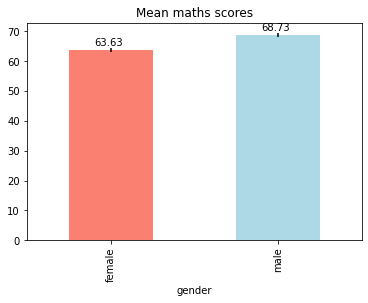

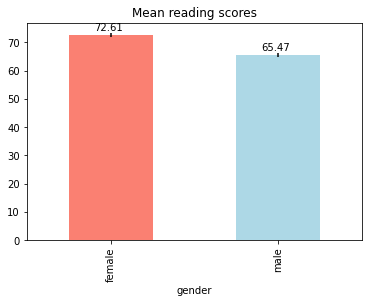

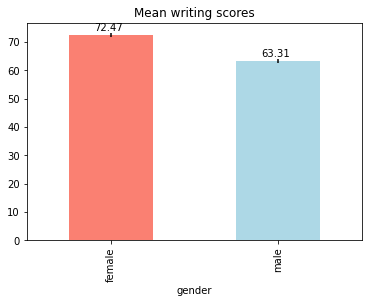

In [10]:
#function to make my life easier later on
def bar_plot(data, bar_value, SD, title, *colors):
    plot=data.plot.bar(y=bar_value, rot=90, yerr=SD, title=title, legend=False, color=colors);
    for i, v in enumerate(data[bar_value]):
        plot.text(i-0.1, v+1.5, str(round(v, 2)))
    
bar_plot(desc_stats_maths_gender, 'Mean',  'SE', 'Mean maths scores', 'salmon', 'lightblue')
bar_plot(desc_stats_reading_gender, 'Mean', 'SE', 'Mean reading scores', 'salmon', 'lightblue')
bar_plot(desc_stats_writing_gender, 'Mean', 'SE', 'Mean writing scores', 'salmon', 'lightblue')


### We can see that depending on the gender some tasks have on average better performance than others, let's see if this is statistically significant

In [11]:
def test_difference_two_groups(data, measure, grouping_variable, group_1, group_2, color_1, color_2):
    #Visualise before distributions
    plt.pyplot.hist(data[measure][data[grouping_variable] == group_1].values, color=color_1, alpha=0.7)
    plt.pyplot.hist(data[measure][data[grouping_variable] == group_2].values, color=color_2, alpha=0.7)
    plt.pyplot.show()
    #assumptions first
    group1_shapiro=stats.shapiro(data[measure][data[grouping_variable] == group_1].values)
    group2_shapiro=stats.shapiro(data[measure][data[grouping_variable] == group_2].values)
    levene_significance=stats.levene(data[measure][data[grouping_variable] == group_1],
             data[measure][data[grouping_variable] == group_2],
             center= 'mean')
    #if assumptions violated for t-test do mann-whitney
    if group1_shapiro[1]<=0.05 or group2_shapiro[1]<=0.05 or levene_significance[1]<=0.05:
        print(f'the significance for differences in {measure} between {group_1} and {group_2} \
              {stats.mannwhitneyu(data[measure][all_data[grouping_variable]==group_1].values, data[measure][all_data[grouping_variable]==group_2].values, use_continuity=True, alternative=None)}') 
        
    else:
        print('the significance for differences in', measure, rp.ttest(group1=data[measure][all_data[grouping_variable]==group_1], group1_name=group_1,
               group2=data[measure][all_data[grouping_variable]==group_2], group2_name=group_2))
        

      

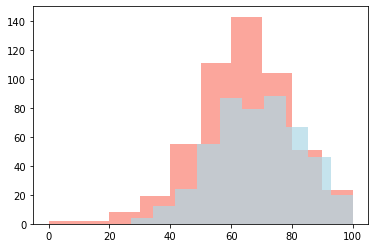

the significance for differences in math_score between female and male               MannwhitneyuResult(statistic=101768.5, pvalue=2.1395383867393836e-07)


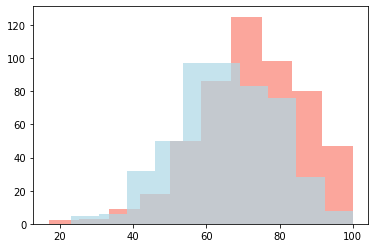

the significance for differences in reading_score between female and male               MannwhitneyuResult(statistic=89168.0, pvalue=2.6869200932318234e-15)


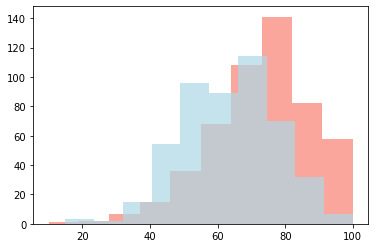

the significance for differences in writing_score between female and male               MannwhitneyuResult(statistic=79719.5, pvalue=2.3345866161695205e-23)


In [13]:
test_difference_two_groups(all_data, 'math_score', 'gender', 'female', 'male', 'salmon', 'lightblue' )    
test_difference_two_groups(all_data, 'reading_score', 'gender', 'female', 'male', 'salmon', 'lightblue')
test_difference_two_groups(all_data, 'writing_score', 'gender', 'female', 'male', 'salmon', 'lightblue')
      

### Conclusion: if you're a female you are likely to be better at writing and reading but males are better at the math test. As a note, the distributions look normal to me, but because something didn't pass either shapiro or levene tests, the function did Mann-Whitney U tests instead of t-tests. This is okay since it's still significant.


## Now let's look at whether preparation had any impact


In [14]:
desc_stats_maths_prep = rp.summary_cont(all_data['math_score'].groupby(all_data['test preparation course']))
desc_stats_reading_prep = rp.summary_cont(all_data['reading_score'].groupby(all_data['test preparation course']))
desc_stats_writing_prep = rp.summary_cont(all_data['writing_score'].groupby(all_data['test preparation course']))
print('Stats for maths:\n', desc_stats_maths_prep)
print('Stats for reading:\n', desc_stats_reading_prep)
print('Stats for writing:\n', desc_stats_writing_prep)








Stats for maths:
                            N     Mean       SD      SE  95% Conf.  Interval
test preparation course                                                    
completed                358  69.6955  14.4447  0.7634    68.1942   71.1969
none                     642  64.0779  15.1924  0.5996    62.9005   65.2553
Stats for reading:
                            N     Mean       SD      SE  95% Conf.  Interval
test preparation course                                                    
completed                358  73.8939  13.6384  0.7208    72.4763   75.3114
none                     642  66.5343  14.4639  0.5708    65.4133   67.6552
Stats for writing:
                            N     Mean       SD      SE  95% Conf.  Interval
test preparation course                                                    
completed                358  74.4190  13.3753  0.7069    73.0288   75.8092
none                     642  64.5047  14.9997  0.5920    63.3422   65.6671


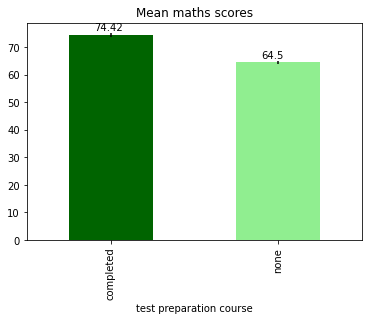

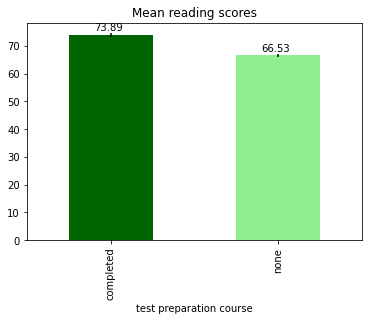

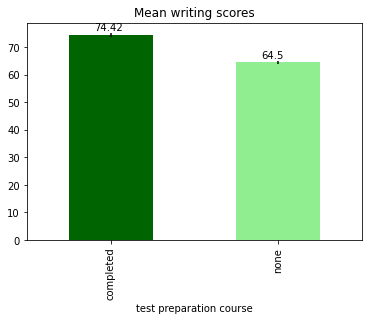

In [356]:
bar_plot(desc_stats_maths_prep, 'Mean',  'SE', 'Mean maths scores', 'darkgreen','lightgreen')
bar_plot(desc_stats_reading_prep, 'Mean', 'SE', 'Mean reading scores', 'darkgreen','lightgreen')
bar_plot(desc_stats_writing_prep, 'Mean', 'SE', 'Mean writing scores', 'darkgreen','lightgreen')


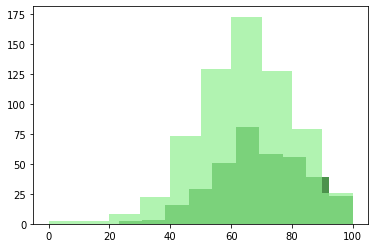

the significance for differences in math_score between completed and none               MannwhitneyuResult(statistic=91424.0, pvalue=4.007587015234774e-08)


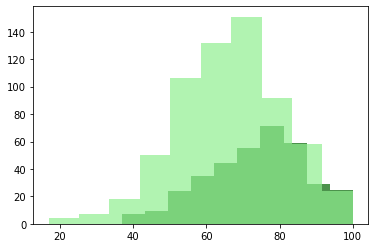

the significance for differences in reading_score between completed and none               MannwhitneyuResult(statistic=81339.0, pvalue=8.558553605690196e-15)


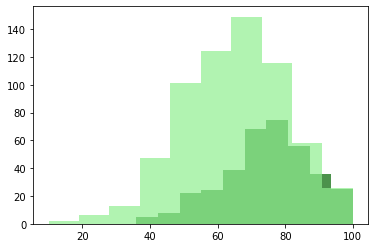

the significance for differences in writing_score between completed and none               MannwhitneyuResult(statistic=71027.0, pvalue=5.853863320835915e-24)


In [15]:
test_difference_two_groups(all_data, 'math_score', 'test preparation course', 'completed', 'none', 'darkgreen','lightgreen')    
test_difference_two_groups(all_data, 'reading_score', 'test preparation course', 'completed', 'none', 'darkgreen','lightgreen')
test_difference_two_groups(all_data, 'writing_score', 'test preparation course', 'completed', 'none', 'darkgreen','lightgreen')

### We can see that in all cases it's better to be prepared. As a caveat, I should mention I'm going by the p-values, but if you look at the confidence intervals in the descriptive stats they're really high, so depending on the school of thought some statisticians might not believe the results.  

## We can maybe get more fancy with it now and add a layer of complexity. Let's start with comparing a three group variable, e.g. parental education level.

In [16]:
desc_stats_maths_ed= rp.summary_cont(all_data['math_score'].groupby(all_data['parental_level_of_education']))
desc_stats_reading_ed = rp.summary_cont(all_data['reading_score'].groupby(all_data['parental_level_of_education']))
desc_stats_writing_ed = rp.summary_cont(all_data['writing_score'].groupby(all_data['parental_level_of_education']))
print('Stats for maths:\n', desc_stats_maths_ed)
print('Stats for reading:\n', desc_stats_reading_ed)
print('Stats for writing:\n', desc_stats_writing_ed)







Stats for maths:
                                N     Mean       SD      SE  95% Conf.  \
parental_level_of_education                                             
associate's degree           222  67.8829  15.1121  1.0143    65.8840   
bachelor's degree            118  69.3898  14.9438  1.3757    66.6654   
high school                  196  62.1378  14.5397  1.0385    60.0895   
master's degree               59  69.7458  15.1539  1.9729    65.7966   
some college                 226  67.1283  14.3129  0.9521    65.2522   
some high school             179  63.4972  15.9280  1.1905    61.1479   

                             Interval  
parental_level_of_education            
associate's degree            69.8817  
bachelor's degree             72.1143  
high school                   64.1860  
master's degree               73.6949  
some college                  69.0045  
some high school              65.8465  
Stats for reading:
                                N     Mean       SD 

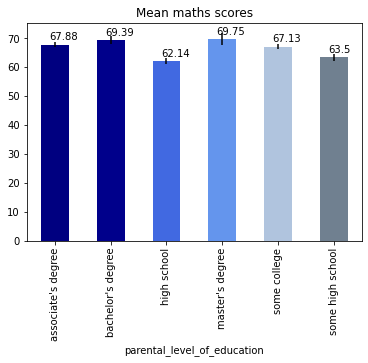

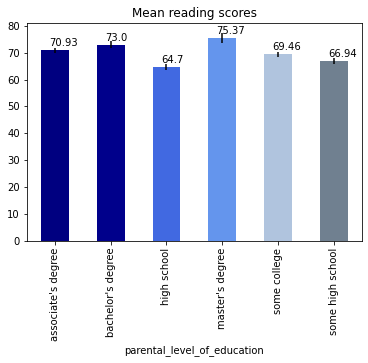

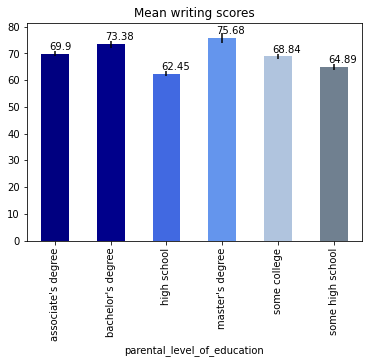

In [17]:
bar_plot(desc_stats_maths_ed, 'Mean',  'SE', 'Mean maths scores', 'navy','darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'slategrey')
bar_plot(desc_stats_reading_ed, 'Mean', 'SE', 'Mean reading scores', 'navy','darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'slategrey')
bar_plot(desc_stats_writing_ed, 'Mean', 'SE', 'Mean writing scores', 'navy','darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'slategrey')

## Now that's all fine but I would love to run some stats and at the moment I only have a function for comparing 2 groups, I need a one-way ANOVA/Kruskal-Wallis 

In [18]:
def multi_group_comp(data, measured_variable, grouped_by_variable, *groups):
    
    model = ols(f'{measured_variable} ~ C({grouped_by_variable})', data=data).fit()
    shapiro=stats.shapiro(model.resid)
    
    #create a string that can later be used as input for functions I'm using 
    statement = ""
    for group in groups:
        statement = statement + f"data[measured_variable][data[grouped_by_variable] == \"{group}\"], "
    statement = statement[:-2]
    levene_query=f"stats.levene({statement})"
    levene_result=eval(levene_query)
    
    if shapiro[1]>0.05 and levene_result[1]>0.05:
        anova_query = f"stats.f_oneway({statement})"
        anova_result = eval(anova_query)
        print(anova_result)
        post_hoc = sc.posthoc_tukey_hsd(data[measured_variable], data[grouped_by_variable])
        print(post_hoc)
    
    kruskal_query=f"stats.kruskal({statement})"
    kruskal_result = eval(kruskal_query)
    print(kruskal_result)
    post_hoc=sc.posthoc_dunn(data, measured_variable, grouped_by_variable)
    print(post_hoc)

In [19]:
print('Maths results:') 
multi_group_comp(all_data, 'writing_score', 'parental_level_of_education', "associate's degree", "bachelor's degree", "high school", "master's degree", "some college", "some high school")
print('\n Reading results:')
multi_group_comp(all_data, 'reading_score', 'parental_level_of_education', "associate's degree", "bachelor's degree", "high school", "master's degree", "some college", "some high school")
print('\n Writing results:')
multi_group_comp(all_data, 'writing_score', 'parental_level_of_education', "associate's degree", "bachelor's degree", "high school", "master's degree", "some college", "some high school")

Maths results:
KruskalResult(statistic=62.330390533062626, pvalue=4.006144326877935e-12)
                    associate's degree  bachelor's degree   high school  \
associate's degree        1.000000e+00       4.895947e-02  9.974273e-07   
bachelor's degree         4.895947e-02       1.000000e+00  1.538350e-09   
high school               9.974273e-07       1.538350e-09  1.000000e+00   
master's degree           1.267970e-02       3.772617e-01  1.288159e-08   
some college              5.960469e-01       1.568953e-02  1.085644e-05   
some high school          4.356669e-03       1.655015e-05  6.181308e-02   

                    master's degree  some college  some high school  
associate's degree     1.267970e-02      0.596047          0.004357  
bachelor's degree      3.772617e-01      0.015690          0.000017  
high school            1.288159e-08      0.000011          0.061813  
master's degree        1.000000e+00      0.004513          0.000014  
some college           4.512623e-03

### Now if we spend some time looking through the pairwise comparisons (which I don't blame you if you don't), we can see that kids whose parents had 'high school' or 'some high school' level of education were on average scoring significantly lower than any other parental education group in the maths and writing tests. They didn't however differ from each other. Similarly the 'high school' group scored lower than other groups (excluding 'some high school') in the reading test and 'some high school' scored lower than most groups.  

# Let's say we wanted to have a model to predict the student's preformance based on what we know about them


### Let's say we're curious about the maths data and want to predict how many students might score below 60, maybe for the purposes of intervening. We will say that those who score below 60 'Fail' and those who score above  'Pass'. 

In [20]:
all_data.head()

gender race/ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math_score  reading_score  writing_score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

In [21]:
writing_data=all_data[['gender', 'race/ethnicity', 'parental_level_of_education', 'lunch', 'test preparation course', 'writing_score']].copy()
writing_data['score_bin']= pd.cut(x=writing_data['writing_score'], bins=[-1,60,100], labels=['Fail', 'Pass'] )
writing_data=writing_data.drop('writing_score', axis=1)

In [22]:
writing_data['score_bin'].value_counts(normalize=True)

Pass    0.699
Fail    0.301
Name: score_bin, dtype: float64

Let's first choose the variables that are relevant. One way of doing this is through a chi2 test that will test the interaction between our variable and the test outcome.

In [23]:
from scipy.stats import chi2_contingency

In [24]:
categorical_columns = writing_data.select_dtypes(exclude = 'number').drop('score_bin', axis = 1).columns

In [25]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(writing_data['score_bin'], writing_data[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

                        Column              Hypothesis
0                       gender  Reject Null Hypothesis
1               race/ethnicity  Reject Null Hypothesis
2  parental_level_of_education  Reject Null Hypothesis
3                        lunch  Reject Null Hypothesis
4      test preparation course  Reject Null Hypothesis


In [26]:
check = {}
for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(writing_data[i])
    bon_p_value = 0.05/writing_data[i].nunique()
    for series in dummies:
        if chi2_contingency(pd.crosstab(writing_data['score_bin'], dummies[series]))[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi = pd.DataFrame(data = [check.keys(), check.values()]).T
res_chi.columns = ['Pair', 'Hypothesis']
res_chi

Pair  \
0                                    gender-female   
1                                      gender-male   
2                           race/ethnicity-group A   
3                           race/ethnicity-group B   
4                           race/ethnicity-group C   
5                           race/ethnicity-group D   
6                           race/ethnicity-group E   
7   parental_level_of_education-associate's degree   
8    parental_level_of_education-bachelor's degree   
9          parental_level_of_education-high school   
10     parental_level_of_education-master's degree   
11        parental_level_of_education-some college   
12    parental_level_of_education-some high school   
13                              lunch-free/reduced   
14                                  lunch-standard   
15               test preparation course-completed   
16                    test preparation course-none   

                        Hypothesis  
0           Reject Null Hypothesis  
1           Reject Null Hypothesis  
2           Reject Null Hypothesis  
3   Fail to Reject Null Hypothesis  
4   Fail to Reject Null Hypothesis  
5   Fail to Reject Null Hypothesis  
6   Fail to Reject Null Hypothesis  
7   Fail to Reject Null Hypothesis  
8           Reject Null Hypothesis  
9           Reject Null Hypothesis  
10          Reject Null Hypothesis  
11  Fail to Reject Null Hypothesis  
12  Fail to Reject Null Hypothesis  
13          Reject Null Hypothesis  
14          Reject Null Hypothesis  
15          Reject Null Hypothesis  
16          Reject Null Hypothesis

In [27]:
data_log = pd.get_dummies(data = writing_data, columns = writing_data.select_dtypes(exclude = 'number').drop('score_bin', axis =1).columns)
#Change the class into numerical value
#data_log['score_bin'] = data_log['score_bin'].apply(lambda x: 0 if x == 'Fail' else 1)
#Splitting the data into Training and Test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_log.drop('score_bin', axis =1), data_log['score_bin'], test_size = 0.30, random_state = 101)
#Creating the prediction model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(X_train, y_train)
#Performance Check
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score
predictions = log_model.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.7633333333333333
              precision    recall  f1-score   support

        Fail       0.63      0.47      0.54        88
        Pass       0.80      0.89      0.84       212

    accuracy                           0.76       300
   macro avg       0.72      0.68      0.69       300
weighted avg       0.75      0.76      0.75       300



In [28]:
#Get the list of all the significant pairwise
significant_chi = []
for i in res_chi[res_chi['Hypothesis'] == 'Reject Null Hypothesis']['Pair']:
    significant_chi.append('{}_{}'.format(i.split('-')[0],i.split('-')[1]))


In [29]:
significant_chi

['gender_female',
 'gender_male',
 'race/ethnicity_group A',
 "parental_level_of_education_bachelor's degree",
 'parental_level_of_education_high school',
 "parental_level_of_education_master's degree",
 'lunch_free/reduced',
 'lunch_standard',
 'test preparation course_completed',
 'test preparation course_none']

In [30]:
#Drop the data with duplicate information
for i in ['gender_female', 'lunch_free/reduced',  'test preparation course_completed']:
    significant_chi.remove(i)
print(significant_chi)

['gender_male', 'race/ethnicity_group A', "parental_level_of_education_bachelor's degree", 'parental_level_of_education_high school', "parental_level_of_education_master's degree", 'lunch_standard', 'test preparation course_none']


In [32]:
log_model = LogisticRegression(max_iter = 1000, class_weight="balanced")
log_model.fit(X_train[significant_chi], y_train)
#Metrics check
from sklearn import metrics
predictions = log_model.predict(X_test[significant_chi])
print(accuracy_score(y_test, predictions), metrics.recall_score(y_test, predictions, pos_label='Fail'), metrics.f1_score(y_test, predictions, pos_label='Fail'))

0.7133333333333334 0.7727272727272727 0.6126126126126127


We now need to encode our values so that the decision tree algorithm can use them. Since the decisions are made based on less/more than basis let's encode the gender, lunch and  test preparation using .LabelEncoder() since all of these can go only two ways so the split will always be okay evaluating one label at a time, but let's use one hot encoder for race and parental education since these are not ordinal values (even though level of education could be, in this case we can't quite say whether 'some college' or 'associates degree' is higher). 

In [33]:
from sklearn.tree import DecisionTreeClassifier

scoreTree=DecisionTreeClassifier(criterion="entropy", max_depth = 5, class_weight='balanced')
scoreTree.fit(X_train[significant_chi], y_train)


DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)

In [34]:
predictions4=scoreTree.predict(X_test[significant_chi]) 
print(accuracy_score(y_test, predictions4), metrics.recall_score(y_test, predictions4, pos_label='Fail'), metrics.f1_score(y_test, predictions4, pos_label='Fail'))

0.7 0.7954545454545454 0.6086956521739131


In [35]:
from sklearn import svm
svmachine=svm.SVC(kernel='rbf', class_weight='balanced')
svmachine.fit(X_train[significant_chi], y_train)
predictions3=svmachine.predict(X_test[significant_chi]) 
print(accuracy_score(y_test, predictions3),metrics.recall_score(y_test, predictions3, pos_label='Fail'), metrics.f1_score(y_test, predictions3, pos_label='Fail'))

0.6966666666666667 0.7840909090909091 0.6026200873362445


In [36]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=4)
KNN.fit(X_train[significant_chi], y_train)
predictions2=KNN.predict(X_test[significant_chi]) 
print(accuracy_score(y_test, predictions2), metrics.recall_score(y_test, predictions2, pos_label='Fail'), metrics.f1_score(y_test, predictions2, pos_label='Fail'))


0.67 0.7727272727272727 0.5787234042553191


In [37]:
from sklearn.ensemble import RandomForestClassifier
randomfor=RandomForestClassifier(n_estimators=100, class_weight='balanced')
randomfor.fit(X_train[significant_chi], y_train)
predictions5=randomfor.predict(X_test[significant_chi]) 
print(accuracy_score(y_test, predictions5), metrics.recall_score(y_test, predictions5, pos_label='Fail'), metrics.f1_score(y_test, predictions5, pos_label='Fail'))


0.7033333333333334 0.7613636363636364 0.600896860986547


In [38]:
pred_list=[predictions, predictions2, predictions3, predictions4, predictions5]
accuracy=[]
recall=[]
F1=[]

for pred in pred_list:
    accuracy.append(metrics.accuracy_score(y_test, pred)*100)
    recall.append(metrics.recall_score(y_test, pred, pos_label='Fail')*100)
    F1.append(metrics.f1_score(y_test, pred, pos_label='Fail'))

In [39]:
results={'Algorithm': ['Logistic regression','KNN', 'SVM', 'Decision Tree Classifier', 'Random Forest Classifier'], 'Accuracy':accuracy,'Recall':recall, 'F1':F1}
results_df=pd.DataFrame(data=results)

In [40]:
results_df.to_csv('student_score_prediction_comparison.csv')

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

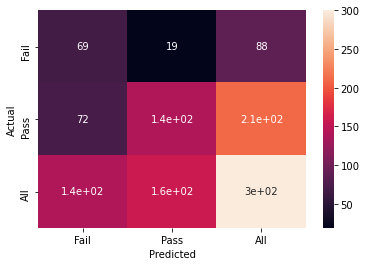

In [41]:
confusion_matrix = pd.crosstab(y_test, predictions3, rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)
